In [296]:
import torch
import inspect
import json
import yaml
import math
import os
import sys

from general_utils import log

import numpy as np
from functools import partial
from os.path import expanduser, join, isfile, basename

from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import LambdaLR
from contextlib import nullcontext
from torch.utils.data import DataLoader

from general_utils import TrainingLogger, get_attribute, filter_args, log, training_config_from_cli_args

SETUP

In [297]:
import models.clipseg
from models.clipseg import forward_multihead_attention

In [298]:
sys.argv=['demo.ipynb','coco.yaml','0']

In [299]:
config = training_config_from_cli_args()
print(config)

{'batch_size': 64, 'optimizer': 'torch.optim.AdamW', 'lr': 0.001, 'trainer': 'experiment_setup.train_loop', 'scorer': 'experiment_setup.score', 'model': 'models.clipseg.CLIPDensePredT', 'lr_scheduler': 'cosine', 'T_max': 7000, 'eta_min': 0.0001, 'max_iterations': 7000, 'val_interval': 1000, 'dataset': 'datasets.coco_wrapper.COCOWrapper', 'split': 'train', 'mask': 'text_and_crop_blur_highlight352', 'image_size': 352, 'normalize': True, 'pre_crop_image_size': ['sample', 1, 1.5], 'aug': '1new', 'mix': True, 'prompt': 'shuffle+', 'norm_cond': True, 'mix_text_min': 0.0, 'out': 1, 'extract_layers': [3, 7, 9], 'reduce_dim': 64, 'depth': 3, 'fix_shift': False, 'loss': 'torch.nn.functional.binary_cross_entropy_with_logits', 'amp': True, 'name': 'rd64-7K-vit16-cbh-coco-0', 'version': 'ViT-B/16', 'fold': 0}


In [300]:
val_interval, best_val_loss, best_val_score = config.val_interval, float('inf'), float('-inf')
print(val_interval,best_val_loss,best_val_score)

1000 inf -inf


Load Model

In [301]:
model = models.clipseg.CLIPDensePredT(prompt='shuffle+', extract_layers= [3,7,9], reduce_dim= 4 , fix_shift= False,version='ViT-B/16')

In [302]:
autocast_fn =autocast
scaler = GradScaler()

Load DataSet

In [303]:
import datasets.coco_wrapper

In [304]:
dataset=datasets.coco_wrapper.COCOWrapper(split='train',mask='text_and_crop_blur_highlight352', image_size=352,aug='1new',fold=0)

In [305]:
batch_size, max_iterations = 4, config.max_iterations
print('batch_size = ',batch_size )

batch_size =  4


In [306]:
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=4)
data_x,data_y= next(iter(data_loader))

In [307]:
import matplotlib.pyplot as plt

def visualize_images(tensor_images):
    tensor_images = tensor_images.cpu()
    
    np_images = tensor_images.numpy().transpose((0, 2, 3, 1))
    
    fig, axs = plt.subplots(1, tensor_images.size(0), figsize=(15, 3))
    
    for i, ax in enumerate(axs):
        # Display the image
        ax.imshow(np_images[i])
        ax.axis('off') 
    plt.show()


In [308]:
print(data_x[1])

('kite', 'bottle', 'bed', 'tie')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 352, 352])


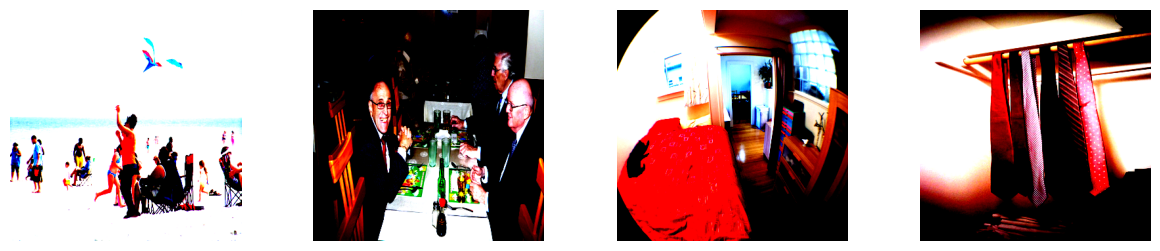

In [309]:
print(data_x[0].shape)
visualize_images(data_x[0])

torch.Size([4, 3, 352, 352])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


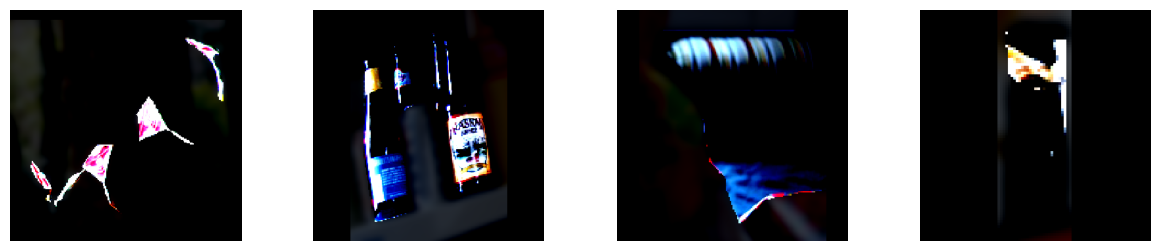

In [310]:
print(data_x[2].shape)
visualize_images(data_x[2])

CLIP Text Transformer

In [311]:
prompts = model.sample_prompts(data_x[1])
prompts

['kite.',
 'a good photo of a bottle.',
 'a photo of one bed.',
 'a photo of a tie.']

Tokenizer Step

In [312]:
from clip.clip import _tokenizer
from clip.simple_tokenizer import re,whitespace_clean,basic_clean
from clip import tokenize

In [313]:
sot_token = _tokenizer.encoder["<|startoftext|>"]
eot_token = _tokenizer.encoder["<|endoftext|>"]
context_length =77

In [314]:
print('Example:' , prompts[0])
bpe_tokens = []
text = whitespace_clean(basic_clean(prompts[0])).lower()
for token in re.findall(_tokenizer.pat, text):
    token = ''.join(_tokenizer.byte_encoder[b] for b in token.encode('utf-8'))
    print(token,end=', ')
    bpe_tokens.extend(_tokenizer.encoder[bpe_token] for bpe_token in _tokenizer.bpe(token).split(' '))
print('\n',bpe_tokens)

tokens = [sot_token] + bpe_tokens + [eot_token]
print(tokens)
result = torch.zeros(1, context_length, dtype=torch.int)
result[0, :len(tokens)] = torch.tensor(tokens)
print(result)

Example: kite.
kite, ., 
 [19867, 269]
[49406, 19867, 269, 49407]
tensor([[49406, 19867,   269, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)


In [315]:
text_tokens = tokenize(prompts)
print(text_tokens.shape)
print(text_tokens)

torch.Size([4, 77])
tensor([[49406, 19867,   269, 49407,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0],
        [49406,   320,   886,  1125,   539,   320,  5392,   269, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,  

Compute Text Projection (Text Conditional Vector)

In [316]:
token_embedding= torch.nn.Embedding(49408, 512)
positional_embedding = torch.nn.Parameter(torch.empty(77,512))

In [317]:
text_cond=token_embedding(text_tokens).type(model.clip_model.dtype)
text_cond=text_cond + positional_embedding.type(model.clip_model.dtype)
print(text_cond.shape)

torch.Size([4, 77, 512])


In [318]:
text_cond=text_cond.permute(1,0,2)
text_cond =model.clip_model.transformer(text_cond)
text_cond.shape

torch.Size([77, 4, 512])

In [319]:
text_cond=text_cond.permute(1,0,2)
text_cond=model.clip_model.ln_final(text_cond).type(model.clip_model.dtype)
text_cond.shape

torch.Size([4, 77, 512])

In [320]:
text_cond = text_cond[torch.arange(text_cond.shape[0]), text_tokens.argmax(dim=-1)]
text_cond.shape

torch.Size([4, 512])

In [321]:
text_cond = text_cond @ model.clip_model.text_projection

CLIP Visual Transformer

In [322]:
conv1 = torch.nn.Conv2d(in_channels=3, out_channels= 768 ,kernel_size=16,stride=16,bias=False)
scale = 768**-0.5
input_resolution = 224
class_embedding = torch.nn.Parameter(scale * torch.randn(768))
positional_embedding = torch.nn.Parameter(scale*torch.randn((input_resolution // 16 )**2 +1,768 ))
inp_size = data_x[0].shape[2:]

In [323]:
visual_cond= conv1(data_x[0])
visual_cond.shape

torch.Size([4, 768, 22, 22])

In [324]:
visual_cond = visual_cond.reshape(visual_cond.shape[0], visual_cond.shape[1], -1)  # shape = [*, width, grid ** 2]
visual_cond = visual_cond.permute(0, 2, 1)  # shape = [*, grid ** 2, width]
visual_cond

tensor([[[ 1.7218e-01, -1.1958e+00, -3.0980e-01,  ...,  9.3779e-01,
           1.6358e-01,  1.6279e+00],
         [ 2.0593e-01, -1.2392e+00, -2.9088e-01,  ...,  9.4751e-01,
           1.4481e-01,  1.6383e+00],
         [ 2.0559e-01, -1.2425e+00, -3.0106e-01,  ...,  9.7415e-01,
           1.3899e-01,  1.6650e+00],
         ...,
         [ 1.4199e-01, -1.3346e+00,  1.3711e-02,  ...,  1.2106e+00,
           1.9230e-02,  1.7388e+00],
         [ 2.3436e-01, -1.1082e+00, -6.5604e-02,  ...,  7.7938e-01,
          -1.6837e-01,  1.6748e+00],
         [ 4.5892e-01, -9.6868e-01, -2.5628e-01,  ...,  5.8731e-01,
          -6.0303e-01,  1.3085e+00]],

        [[-1.8305e-01,  1.1086e+00,  2.2305e-01,  ..., -9.1911e-01,
           2.6139e-02, -1.5395e+00],
         [-3.3959e-01,  1.0136e+00,  1.1019e-01,  ..., -7.8997e-01,
           9.8690e-02, -1.5280e+00],
         [-2.3465e-01,  8.0912e-01, -1.0025e-01,  ..., -1.0495e+00,
          -1.0278e-01, -1.6484e+00],
         ...,
         [-1.2418e-01,  7

Embedding

In [325]:
class_embedding = class_embedding.to(visual_cond.dtype)
print(class_embedding.shape)
print(class_embedding)

torch.Size([768])
Parameter containing:
tensor([-0.0286, -0.0257, -0.0235, -0.0086, -0.0545,  0.0264, -0.0091, -0.0279,
         0.0476, -0.0125,  0.0029, -0.0147, -0.0051, -0.0154, -0.0193, -0.0450,
        -0.0291,  0.0502, -0.0008,  0.0430, -0.0218,  0.0291, -0.0308, -0.0463,
        -0.0148, -0.0573, -0.0188, -0.0417,  0.0241,  0.0337,  0.0227,  0.0377,
        -0.0353,  0.0062, -0.0210, -0.0278,  0.0423,  0.0396,  0.0039, -0.0470,
         0.0261,  0.0310, -0.0263,  0.0313, -0.0376,  0.0422, -0.0132, -0.0034,
         0.0432, -0.0295,  0.0460, -0.0003, -0.0037,  0.0199,  0.0003,  0.0147,
        -0.0104, -0.0423, -0.0593,  0.0310,  0.0085,  0.0562,  0.0451, -0.0123,
        -0.0579,  0.0016, -0.0375, -0.0462, -0.0047, -0.0453,  0.0012, -0.0261,
        -0.0113,  0.0642,  0.0101,  0.0004, -0.0319,  0.0021,  0.0229,  0.0490,
         0.0078, -0.0255, -0.0422,  0.0153,  0.0230,  0.0166,  0.0056, -0.0335,
        -0.0144, -0.0467,  0.0689,  0.0527,  0.0427, -0.0218, -0.0061, -0.1254,


In [326]:
visual_cond = torch.cat([class_embedding + torch.zeros(visual_cond.shape[0], 1, visual_cond.shape[-1], dtype=visual_cond.dtype, device=visual_cond.device), visual_cond], dim=1)  # shape = [*, grid ** 2 + 1, width]
print(visual_cond.shape)
visual_cond

torch.Size([4, 485, 768])


tensor([[[-2.8579e-02, -2.5680e-02, -2.3452e-02,  ..., -2.3052e-02,
          -4.1408e-02, -7.8620e-02],
         [ 1.7218e-01, -1.1958e+00, -3.0980e-01,  ...,  9.3779e-01,
           1.6358e-01,  1.6279e+00],
         [ 2.0593e-01, -1.2392e+00, -2.9088e-01,  ...,  9.4751e-01,
           1.4481e-01,  1.6383e+00],
         ...,
         [ 1.4199e-01, -1.3346e+00,  1.3711e-02,  ...,  1.2106e+00,
           1.9230e-02,  1.7388e+00],
         [ 2.3436e-01, -1.1082e+00, -6.5604e-02,  ...,  7.7938e-01,
          -1.6837e-01,  1.6748e+00],
         [ 4.5892e-01, -9.6868e-01, -2.5628e-01,  ...,  5.8731e-01,
          -6.0303e-01,  1.3085e+00]],

        [[-2.8579e-02, -2.5680e-02, -2.3452e-02,  ..., -2.3052e-02,
          -4.1408e-02, -7.8620e-02],
         [-1.8305e-01,  1.1086e+00,  2.2305e-01,  ..., -9.1911e-01,
           2.6139e-02, -1.5395e+00],
         [-3.3959e-01,  1.0136e+00,  1.1019e-01,  ..., -7.8997e-01,
           9.8690e-02, -1.5280e+00],
         ...,
         [-1.2418e-01,  7

In [327]:
new_shape = int(math.sqrt(visual_cond.shape[1]-1))
visual_cond=visual_cond+ model.rescaled_pos_emb((new_shape,new_shape)).to(visual_cond.dtype)[None, : , :]
print(visual_cond.shape)
print(visual_cond)

torch.Size([4, 485, 768])
tensor([[[-2.8435e-02, -6.7720e-02,  3.8404e-02,  ...,  5.6139e-02,
           3.5882e-02, -7.8617e-02],
         [ 1.6272e-01, -1.2124e+00, -2.6429e-01,  ...,  8.8929e-01,
           1.1513e-01,  1.7071e+00],
         [ 1.9552e-01, -1.2576e+00, -2.6129e-01,  ...,  9.0684e-01,
           1.0898e-01,  1.6892e+00],
         ...,
         [ 1.4711e-01, -1.3535e+00,  1.6228e-02,  ...,  1.1607e+00,
          -1.9751e-02,  1.7340e+00],
         [ 2.4081e-01, -1.1300e+00, -9.3610e-02,  ...,  7.8130e-01,
          -2.1129e-01,  1.7021e+00],
         [ 4.6601e-01, -9.9151e-01, -3.2139e-01,  ...,  6.3396e-01,
          -6.5193e-01,  1.3660e+00]],

        [[-2.8435e-02, -6.7720e-02,  3.8404e-02,  ...,  5.6139e-02,
           3.5882e-02, -7.8617e-02],
         [-1.9250e-01,  1.0920e+00,  2.6856e-01,  ..., -9.6760e-01,
          -2.2311e-02, -1.4603e+00],
         [-3.5000e-01,  9.9524e-01,  1.3979e-01,  ..., -8.3064e-01,
           6.2865e-02, -1.4772e+00],
         ...,

In [328]:
visual_cond = model.model.ln_pre(visual_cond)

visual_cond = visual_cond.permute(1, 0, 2)  # NLD -> LND
visual_cond.shape

torch.Size([485, 4, 768])

Transformer

In [329]:
affinities, activations = [],[]
for i, res_block in enumerate(model.model.transformer.resblocks):
        
    attn_mask = None
    visual_cond, aff_per_head = forward_multihead_attention(visual_cond, res_block, with_aff=True, attn_mask=attn_mask)
    
    if i in [3,7,9]:
        affinities += [aff_per_head]
        activations += [visual_cond]

visual_cond = visual_cond.permute(1,0,2) # LND -> NLD
visual_cond = model.model.ln_post(visual_cond[:,0,:])
visual_cond.shape

torch.Size([4, 768])

In [330]:
visual_cond =visual_cond @ model.model.proj
visual_cond.shape

torch.Size([4, 512])

In [331]:
max_txt = config.mix_text_max if config.mix_text_max is not None else 1
text_weights = torch.distributions.Uniform(config.mix_text_min, max_txt).sample((batch_size,))[:, None]

cond =text_cond * text_weights + visual_cond * (1-text_weights)

CLIP SEG Decoder

In [332]:
film_mul = torch.nn.Linear(512, 4)
film_add = torch.nn.Linear(512, 4)  
reduces = torch.nn.ModuleList([torch.nn.Linear(768, 4) for _ in range(3)])
trans_conv =torch.nn.ConvTranspose2d(4,1,(16,16), (16,16))

In [333]:
inp_image = data_x[0].to(model.model.positional_embedding.device)

# x_inp = normalize(inp_image)
x_inp = inp_image
dev = x_inp.device
cond = model.get_cond_vec(cond, batch_size)
visual_q, activations, _ = model.visual_forward(x_inp, extract_layers=[0] + list(model.extract_layers))

activation1 = activations[0]
activations = activations[1:]

torch.Size([4, 512])


In [334]:
activations[0].shape

torch.Size([485, 4, 768])

In [335]:
film_mul(cond).shape

torch.Size([4, 4])

In [336]:

a = None
for i, (activation, block, reduce) in enumerate(zip(activations, model.blocks, reduces)):
    if a is not None:
        a = reduce(activation) + a
    else:
        a = reduce(activation)
    if i == model.cond_layer:
        
        a = film_mul(cond) * a + film_add(cond)
    a = block(a)
    print(a.shape)

torch.Size([485, 4, 4])
torch.Size([485, 4, 4])
torch.Size([485, 4, 4])
torch.Size([485, 4, 4])


In [337]:

a = a[1:].permute(1, 2, 0) # rm cls token and -> BS, Feats, Tokens
print(a.shape)
size = int(math.sqrt(a.shape[2]))
a = a.view(batch_size, a.shape[1], size, size)
print(a.shape)
a = trans_conv(a)

torch.Size([4, 4, 484])
torch.Size([4, 4, 22, 22])


In [338]:
a.shape

torch.Size([4, 1, 352, 352])

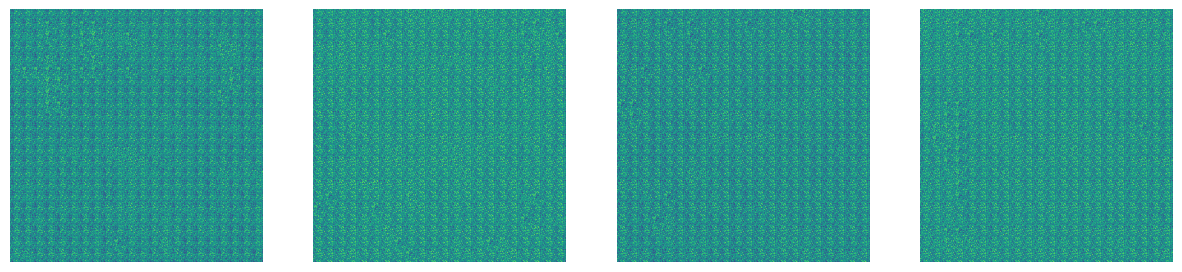

In [339]:
_, ax = plt.subplots(1, 4, figsize=(15, 4))
[a.axis('off') for a in ax.flatten()]
for i in range(4):
    ret = torch.sigmoid(a[i][0]).detach().numpy()
    ax[i].imshow(ret)